In [51]:
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch, torch.nn as nn, torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder 
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant


Caricamento dei Dati

In [62]:
df = pd.read_csv("D:\\Home price\\data\\train.csv")
target=df['SalePrice']

Controllo degli outliers (verranno comunque tenuti tutti i dati data la piccola taglia del dataset)

In [65]:
# funzione che conta gli outlier > 3 sigma
def count_outliers_iqr(x):
    q1 = x.quantile(0.25)   # 25° percentile
    q3 = x.quantile(0.75)   # 75° percentile
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    return ((x < lower) | (x > upper)).sum()

outliers = df.groupby("Neighborhood")["SalePrice"].apply(count_outliers_iqr)
print(outliers)

Neighborhood
Blmngtn     0
Blueste     0
BrDale      0
BrkSide     6
ClearCr     0
CollgCr     2
Crawfor     3
Edwards     5
Gilbert     8
IDOTRR      0
MeadowV     0
Mitchel     3
NAmes      13
NPkVill     0
NWAmes      4
NoRidge     4
NridgHt     2
OldTown     8
SWISU       1
Sawyer      4
SawyerW     0
Somerst     2
StoneBr     0
Timber      0
Veenker     0
Name: SalePrice, dtype: int64


Analisi dei dati mancanti, le feature con più del 40% di missing values vengono rigettate

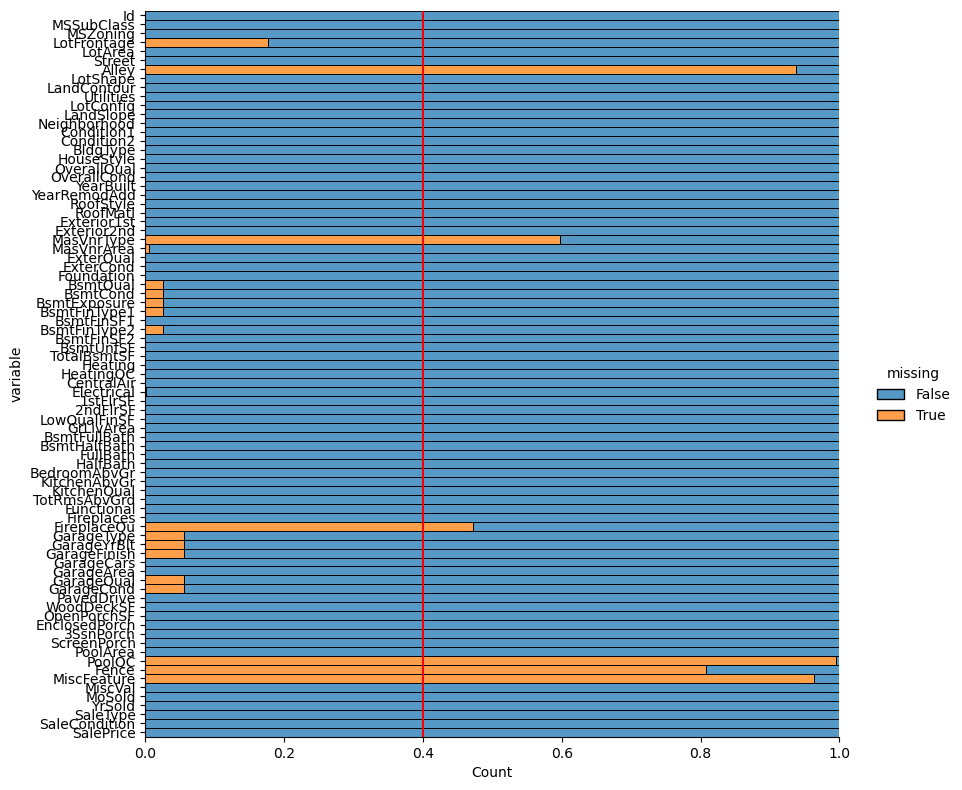

In [68]:
sns.displot(
    data=df.isnull().melt(value_name='missing'),
    y='variable',
    hue='missing',
    multiple='fill',
    height=8,
    aspect=1.1
)

# specifying a threshold value
plt.axvline(0.4, color='r')

In [69]:
df = df.drop(columns=["PoolQC", "Fence","MiscFeature","MasVnrType", "Alley", "FireplaceQu","SalePrice","Id"])

Imputazione manuale dei dati mancanti (la maggior parte son case che non posseggono quella caratteristica, es. non hanno il garage)

In [71]:
#manual Imputation

df["BsmtQual"] = df["BsmtQual"].fillna("NA")
df["BsmtCond"] = df["BsmtCond"].fillna("NA")
df["BsmtExposure"] = df["BsmtExposure"].fillna("NA")
df["BsmtFinType1"] = df["BsmtFinType1"].fillna("NA")
df["BsmtFinType2"] = df["BsmtFinType2"].fillna("NA")


df["GarageYrBlt_missing"] = df["GarageYrBlt"].isna().astype(int)
df["GarageYrBlt"] = df["GarageYrBlt"].fillna(0)

df["GarageType"] = df["GarageType"].fillna("NA")
df["GarageFinish"] = df["GarageFinish"].fillna("NA")
df["GarageCond"] = df["GarageCond"].fillna("NA")
df["GarageQual"] = df["GarageQual"].fillna("NA")

df["MasVnrArea"] = df["MasVnrArea"].fillna(0)


df['LotFrontage'] = df.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

'''
df["LotFrontage_missing"] = df["LotFrontage"].isna().astype(int)
df["LotFrontage"] = df.groupby("Neighborhood")["LotFrontage"].transform(
    lambda s: s.fillna(s.median())
)
'''

'\ndf["LotFrontage_missing"] = df["LotFrontage"].isna().astype(int)\ndf["LotFrontage"] = df.groupby("Neighborhood")["LotFrontage"].transform(\n    lambda s: s.fillna(s.median())\n)\n'

Feature engineering, creazione e fusione di feature utili per rappresentare il contesto, come per esempio luxury home è una flag che ho creato per ridurre l'errore sulle case con costo>500K

In [76]:
# Età / anni
df["Age"]      = (df["YrSold"] - df["YearBuilt"]).clip(lower=0)
df["RemodAge"] = (df["YrSold"] - df["YearRemodAdd"]).clip(lower=0)
df["GarageAge"] = (df["YrSold"] - df["GarageYrBlt"]).clip(lower=0)

# Superficie totale casa
df["TotalSF"] = df[["TotalBsmtSF","1stFlrSF","2ndFlrSF"]].sum(axis=1)

# Bagni totali
df["TotalBath"] = (df["BsmtFullBath"] + 0.5*df["BsmtHalfBath"] +
                   df["FullBath"]     + 0.5*df["HalfBath"])

# Superficie portici
df["TotalPorchSF"] = df[["OpenPorchSF","EnclosedPorch","3SsnPorch","ScreenPorch"]].sum(axis=1)

df["LotAreaRatio"]=df["LotArea"]/df["LotFrontage"]

df["Bath_over_bedrooms"]=df["TotalBath"]/df["TotRmsAbvGrd"]

df["Area_per_Qual"]=df["GrLivArea"]*df["OverallQual"]

df['LuxuryHome'] = (
    (df['GrLivArea'] > 2000) &            
    (df['OverallQual'] >= 9) &            
    (df['GarageCars'] >= 3)  &             
    (df['TotalBsmtSF'] > 1000)&          
    (df['Age'] <= 20) &                
    (df['TotalSF'] >= 4200) &
    (df['LotFrontage'] >= 80) &
    (df['TotalBath'] >= 3) &
    (df["TotRmsAbvGrd"] >=10)
    
).astype(int)

In [78]:
num_cols = df.select_dtypes(include=["number"])
cat_cols = df.select_dtypes(include=["object", "category"])

Studio delle correlazioni

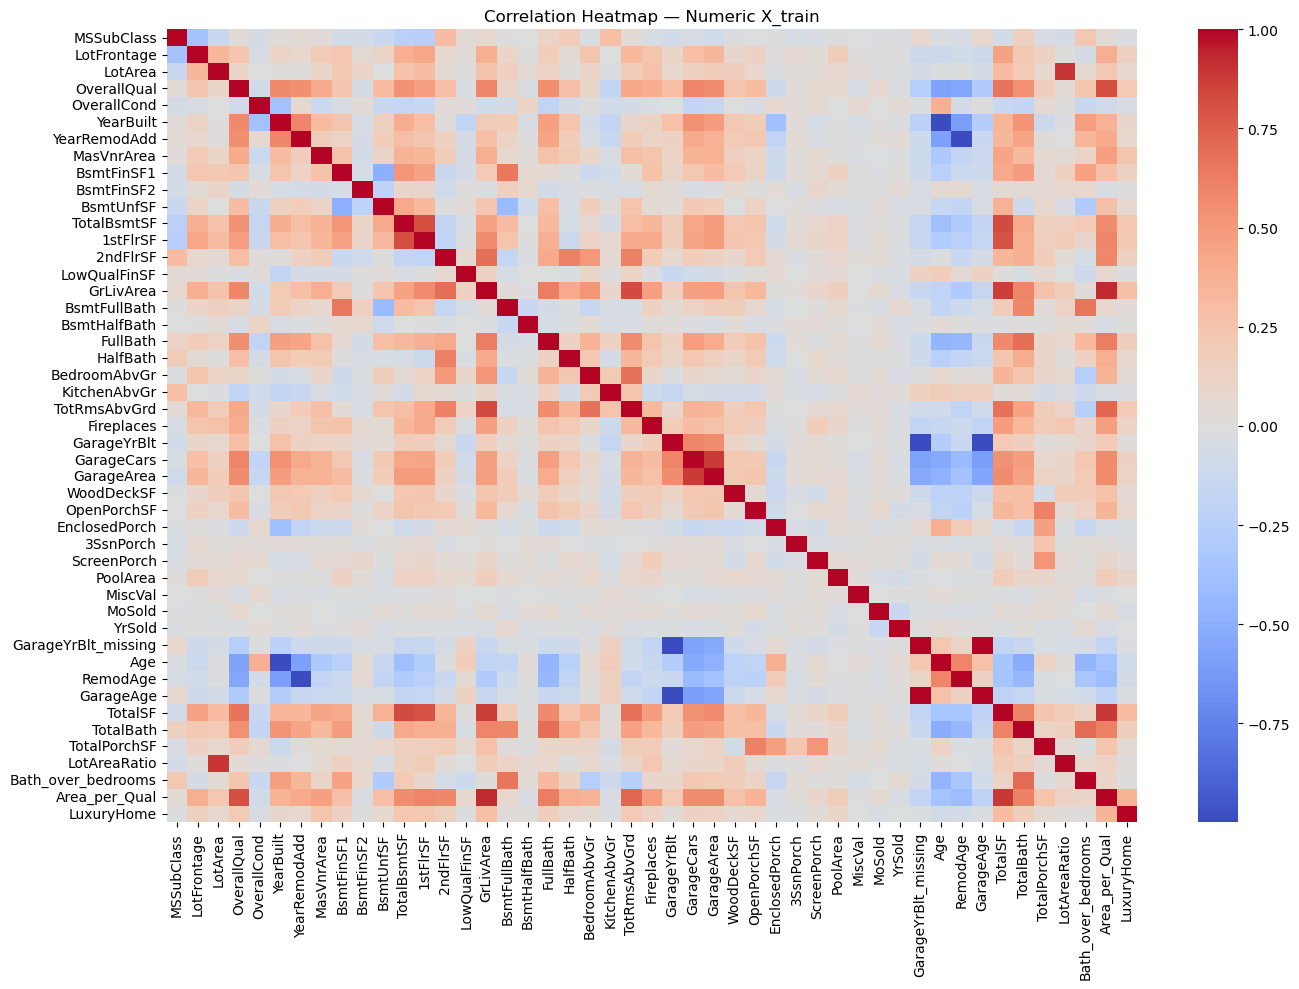

In [81]:
corr_matrix=num_cols.corr()
plt.figure(figsize=(14, 10))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=False)
plt.title("Correlation Heatmap — Numeric X_train")
plt.tight_layout()
plt.show()

Print feature con corr>0.8

In [84]:
high_corr_line=[]

for col in range(len(corr_matrix.columns)):
    for line in range(col):
        if(abs(corr_matrix.iloc[col,line])>0.8):
            col1 = corr_matrix.columns[col]
            col2 = corr_matrix.columns[line]
            high_corr_line.append((col1,col2,abs(corr_matrix.iloc[col,line])))

for pair in high_corr_line:
    print(f"{pair[0]} <-> {pair[1]}:  \t            {pair[2]}")

1stFlrSF <-> TotalBsmtSF:  	            0.8195299750050339
TotRmsAbvGrd <-> GrLivArea:  	            0.8254893743088425
GarageArea <-> GarageCars:  	            0.882475414281462
GarageYrBlt_missing <-> GarageYrBlt:  	            0.99860051564718
Age <-> YearBuilt:  	            0.9990359444033182
RemodAge <-> YearRemodAdd:  	            0.9979308897647804
GarageAge <-> GarageYrBlt:  	            0.9999957163789118
GarageAge <-> GarageYrBlt_missing:  	            0.998596176248465
TotalSF <-> TotalBsmtSF:  	            0.8267423791406745
TotalSF <-> 1stFlrSF:  	            0.8003499326002395
TotalSF <-> GrLivArea:  	            0.8743728652580669
LotAreaRatio <-> LotArea:  	            0.8943988379970543
Area_per_Qual <-> OverallQual:  	            0.8101651994829745
Area_per_Qual <-> GrLivArea:  	            0.9286576400677296
Area_per_Qual <-> TotalSF:  	            0.8861375000859266


Utilizzo il VIF, ossia la misura di quanto la varianza della stima di un coefficiente in una regressione lineare è gonfiata dalla multicollinearità tra le variabili esplicative, per decidere quali feature eliminare. Se VIF>5 le feature sono moooolto collineari.

In [87]:
X = num_cols.dropna()
X = X.loc[:, X.std() > 0]  
X_const = add_constant(X)

# Compute VIF
vif = pd.Series(
    [variance_inflation_factor(X_const.values, i) for i in range(X_const.shape[1])],
    index=X_const.columns
)

# Display sorted VIF values
print(vif.sort_values(ascending=False))

HalfBath                        inf
GarageYrBlt                     inf
EnclosedPorch                   inf
3SsnPorch                       inf
GarageAge                       inf
FullBath                        inf
BsmtHalfBath                    inf
BsmtFullBath                    inf
GrLivArea                       inf
LowQualFinSF                    inf
2ndFlrSF                        inf
1stFlrSF                        inf
TotalBsmtSF                     inf
BsmtUnfSF                       inf
BsmtFinSF2                      inf
BsmtFinSF1                      inf
ScreenPorch                     inf
TotalPorchSF                    inf
YearBuilt                       inf
TotalBath                       inf
TotalSF                         inf
YrSold                          inf
Age                             inf
OpenPorchSF                     inf
const                  2.420814e+06
YearRemodAdd           7.490482e+05
RemodAge               7.486296e+05
GarageYrBlt_missing    1.432

D:\anaconda\Nuova cartella\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


In [89]:
num_cols = df.select_dtypes(include=["number"])
corr_matrix=num_cols.corr()

drop_cols = [
    "1stFlrSF",
    #"TotalBsmtSF",
    "BsmtFinSF2",
    "BsmtUnfSF",
    "BsmtFinSF1",
    "YearBuilt",
    "GarageYrBlt",
    "HalfBath",
    "FullBath",
    "BsmtHalfBath",
    "BsmtFullBath",
    #"GrLivArea",
    "LowQualFinSF",
    "2ndFlrSF",
    #"TotalPorchSF",
    #"Age",
    #"TotalBath",
    "YrSold",
    "ScreenPorch",
    "3SsnPorch",
    "EnclosedPorch",
    "OpenPorchSF",
    #"GarageAge",
    #"TotalSF",
    "LotArea",
    #"GarageYrBlt",
    "YearRemodAdd",
    #"YearBuilt",
    "GarageCars",
]

df.drop(columns=drop_cols, inplace=True)
num_cols = df.select_dtypes(include=["number"])
corr_matrix=num_cols.corr()

X = num_cols.dropna()
X = X.loc[:, X.std() > 0]  
X_const = add_constant(X)

# Compute VIF
vif = pd.Series(
    [variance_inflation_factor(X_const.values, i) for i in range(X_const.shape[1])],
    index=X_const.columns
)

# Display sorted VIF values
print(vif.sort_values(ascending=False))

high_corr_line=[]

for col in range(len(corr_matrix.columns)):
    for line in range(col):
        if(abs(corr_matrix.iloc[col,line])>0.8):
            col1 = corr_matrix.columns[col]
            col2 = corr_matrix.columns[line]
            high_corr_line.append((col1,col2,abs(corr_matrix.iloc[col,line])))

for pair in high_corr_line:
    print(f"{pair[0]} <-> {pair[1]}:  \t            {pair[2]}")

GarageAge              1455.000674
GarageYrBlt_missing    1405.392001
const                   373.379918
TotalSF                 332.343772
GrLivArea               154.580135
TotalBsmtSF              96.478370
Area_per_Qual            48.021992
TotalBath                19.053177
Bath_over_bedrooms       16.072195
TotRmsAbvGrd             13.615744
OverallQual              10.068020
Age                       4.798669
GarageArea                3.040371
RemodAge                  2.373950
BedroomAbvGr              2.324136
MSSubClass                1.718261
LotFrontage               1.632332
Fireplaces                1.536089
OverallCond               1.530635
KitchenAbvGr              1.521566
MasVnrArea                1.419842
LuxuryHome                1.383074
TotalPorchSF              1.231198
WoodDeckSF                1.213577
LotAreaRatio              1.150776
PoolArea                  1.126174
MoSold                    1.021524
MiscVal                   1.018376
dtype: float64
TotRm

Studio la skev delle feature, per le feature con skeaw>1 e senza numeri negativi presenti ne calcolo e utilizzo il logaritmo per ridurne la scala

In [92]:
num_cols = df.select_dtypes(include=["number"])
skew_vals = num_cols.skew()

exclude = {"LuxuryHouse", "LuxuryHome"}
candidates = [
    c for c in num_cols.columns
    if (skew_vals[c] > 1)        # skewed
    and (df[c].min() >= 0)       # niente negativi
    and (c not in exclude)
]

print("Colonne trasformate con log1p:", candidates)

# --- applica log1p al TRAIN ---
df[candidates] = np.log1p(df[candidates])

# --- applica log1p al TEST usando ESATTAMENTE le stesse colonne ---
if 'test_df' in globals():
    missing_in_test = [c for c in candidates if c not in test_df.columns]
    if missing_in_test:
        print("Colonne assenti nel test:", missing_in_test)

    cols_test = [c for c in candidates if c in test_df.columns]
    test_df[cols_test] = np.log1p(test_df[cols_test])

# --- target log-transform ---
target = np.log1p(target)

Colonne trasformate con log1p: ['MSSubClass', 'LotFrontage', 'MasVnrArea', 'TotalBsmtSF', 'GrLivArea', 'KitchenAbvGr', 'WoodDeckSF', 'PoolArea', 'MiscVal', 'GarageYrBlt_missing', 'GarageAge', 'TotalSF', 'TotalPorchSF', 'LotAreaRatio', 'Area_per_Qual']
